# Fake Review Detection using LSTM

This notebook implements an LSTM-based model to detect fake reviews from restaurant review data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Import Required Libraries

In [ ]:
# Install required packages if needed
# !pip install tensorflow pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


## 2. Load and Explore Data

In [ ]:
# Load the datasets
train_df = pd.read_csv('/content/drive/MyDrive/CSE 573 Semantic Web Mining/LSTM/new_data_train.csv', sep='\t')
test_df = pd.read_csv('/content/drive/MyDrive/CSE 573 Semantic Web Mining/LSTM/new_data_test.csv', sep='\t')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print("\nTraining data info:")
print(train_df.info())
print("\nFirst few rows:")
print(train_df.head())

Training data shape: (9929, 23)
Test data shape: (2483, 23)

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9929 entries, 0 to 9928
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         9929 non-null   int64  
 1   reviewID           9929 non-null   object 
 2   reviewerID         9929 non-null   object 
 3   restaurantID       9929 non-null   object 
 4   date               9929 non-null   object 
 5   rating             9929 non-null   int64  
 6   reviewUsefulCount  9929 non-null   int64  
 7   reviewContent      9926 non-null   object 
 8   flagged            9929 non-null   int64  
 9   name               9929 non-null   object 
 10  location           9928 non-null   object 
 11  yelpJoinDate       9929 non-null   object 
 12  friendCount        9929 non-null   int64  
 13  reviewCount        9929 non-null   int64  
 14  firstCount         9929 non-null   int6

In [ ]:
# Check class distribution
print("\nClass distribution in training data:")
print(train_df['flagged'].value_counts())
print("\nPercentage:")
print(train_df['flagged'].value_counts(normalize=True) * 100)

print("\nClass distribution in test data:")
print(test_df['flagged'].value_counts())
print("\nPercentage:")
print(test_df['flagged'].value_counts(normalize=True) * 100)


Class distribution in training data:
flagged
0    4994
1    4935
Name: count, dtype: int64

Percentage:
flagged
0    50.297109
1    49.702891
Name: proportion, dtype: float64

Class distribution in test data:
flagged
1    1271
0    1212
Name: count, dtype: int64

Percentage:
flagged
1    51.188079
0    48.811921
Name: proportion, dtype: float64


## 3. Data Preprocessing

In [ ]:
def clean_text(text):
    """
    Clean and preprocess text data
    """
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = str(text).lower()

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply cleaning to review content
print("Cleaning text data...")
train_df['cleaned_review'] = train_df['reviewContent'].apply(clean_text)
test_df['cleaned_review'] = test_df['reviewContent'].apply(clean_text)

# Remove empty reviews
train_df = train_df[train_df['cleaned_review'] != '']
test_df = test_df[test_df['cleaned_review'] != '']

print(f"\nAfter cleaning - Training samples: {len(train_df)}")
print(f"After cleaning - Test samples: {len(test_df)}")

Cleaning text data...

After cleaning - Training samples: 9926
After cleaning - Test samples: 2483


In [ ]:
# Prepare data for model
X_train = train_df['cleaned_review'].values
y_train = train_df['flagged'].values

X_test = test_df['cleaned_review'].values
y_test = test_df['flagged'].values

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (9926,)
y_train shape: (9926,)
X_test shape: (2483,)
y_test shape: (2483,)


## 4. Tokenization and Sequence Padding

In [ ]:
# Tokenization parameters
MAX_WORDS = 10000  # Maximum number of words to keep
MAX_SEQUENCE_LENGTH = 200  # Maximum length of each sequence

# Initialize and fit tokenizer
print("Tokenizing text...")
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"\nVocabulary size: {len(tokenizer.word_index) + 1}")
print(f"X_train_padded shape: {X_train_padded.shape}")
print(f"X_test_padded shape: {X_test_padded.shape}")

Tokenizing text...

Vocabulary size: 24469
X_train_padded shape: (9926, 200)
X_test_padded shape: (2483, 200)


In [ ]:
# Split training data for validation
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_padded, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training samples: {len(X_train_final)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test_padded)}")

Training samples: 7940
Validation samples: 1986
Test samples: 2483


## 5. Build LSTM Model

In [ ]:
# Model parameters
EMBEDDING_DIM = 128
LSTM_UNITS = 128
DROPOUT_RATE = 0.5

# Build the model
def create_lstm_model(vocab_size, embedding_dim, lstm_units, dropout_rate, max_length):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        LSTM(lstm_units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the model
vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1)
model = create_lstm_model(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    lstm_units=LSTM_UNITS,
    dropout_rate=DROPOUT_RATE,
    max_length=MAX_SEQUENCE_LENGTH
)

# Display model architecture
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 6. Train the Model

In [ ]:
# Training parameters
BATCH_SIZE = 32
EPOCHS = 10

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'lstm_fake_review_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train the model
print("\nTraining the model...")
history = model.fit(
    X_train_final, y_train_final,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

print("\nTraining completed")


Training the model...
Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.5006 - loss: 0.6947
Epoch 1: val_accuracy improved from -inf to 0.50302, saving model to lstm_fake_review_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 86s 337ms/step - accuracy: 0.5006 - loss: 0.6947 - val_accuracy: 0.5030 - val_loss: 0.6903
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.5080 - loss: 0.7095
Epoch 2: val_accuracy improved from 0.50302 to 0.52417, saving model to lstm_fake_review_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 141s 334ms/step - accuracy: 0.5080 - loss: 0.7094 - val_accuracy: 0.5242 - val_loss: 0.6866
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.5127 - loss: 0.6973
Epoch 3: val_accuracy did not improve from 0.52417
249/249 ━━━━━━━━━━━━━━━━━━━━ 83s 333ms/step - accuracy: 0.5127 - loss: 0.6974 - val_accuracy: 0.5030 - val_loss: 0.6913
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.5056 - loss: 0.7018
Epoch 4: val_accuracy did not improve from 0.52417
249/249 ━━━━━━━━━━━━━━━━━━━━ 82s 330ms/step - accuracy: 0.5057 - loss: 0.7018 - val_accuracy: 0.5030 - val_loss: 0.6899
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.5164 - loss: 0.6915
Epoch 5: val_accuracy did not improve from 0.52417
249/249 ━━━━━━━━━━━━━━━━━━━━ 142s 327ms/step - accuracy: 0.5164 - loss: 0.6915 - val_accuracy: 0.5030 - val_loss: 0.6885
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.

Training complete

## 7. Load Best Model and Make Predictions

In [ ]:
# Load the best saved model
print("Loading best model...")
best_model = load_model('lstm_fake_review_model.h5')

# Make predictions on test set
print("Making predictions on test set...")
y_pred_prob = best_model.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Convert predictions to labels
prediction_labels = ['Fake Review' if pred == 1 else 'Real Review' for pred in y_pred]
actual_labels = ['Fake Review' if actual == 1 else 'Real Review' for actual in y_test]

print(f"\nPredictions completed. Total predictions: {len(y_pred)}")

Loading best model...
Making predictions on test set...
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step

Predictions completed. Total predictions: 2483


## 8. Evaluate Model Performance

In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n" + "="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("="*50)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Real Review', 'Fake Review']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


MODEL PERFORMANCE METRICS
Accuracy:  0.5417
Precision: 0.5286
Recall:    0.9670
F1-Score:  0.6835

Classification Report:
              precision    recall  f1-score   support

 Real Review       0.73      0.10      0.17      1212
 Fake Review       0.53      0.97      0.68      1271

    accuracy                           0.54      2483
   macro avg       0.63      0.53      0.43      2483
weighted avg       0.63      0.54      0.43      2483


Confusion Matrix:
[[ 116 1096]
 [  42 1229]]


## 9. Save Predictions

In [ ]:
# Create predictions dataframe
predictions_df = pd.DataFrame({
    'reviewContent': test_df['reviewContent'].values,
    'actual_label': actual_labels,
    'predicted_label': prediction_labels,
    'confidence': y_pred_prob.flatten()
})

# Save to CSV
predictions_df.to_csv('predictions.csv', index=False)
print("Predictions saved to 'predictions.csv'")

# Display sample predictions
print("\nSample Predictions (First 10 rows):")
print(predictions_df[['reviewContent', 'actual_label', 'predicted_label', 'confidence']].head(10))

Predictions saved to 'predictions.csv'

Sample Predictions (First 10 rows):
                                       reviewContent actual_label  \
0  sunda amazing i heard many good things finally...  Fake Review   
1  absolutely fantastic foodie community table gr...  Real Review   
2  i work right rarely go here they 5 personal st...  Real Review   
3  this best big 3 brazilian steakhouses chicago ...  Fake Review   
4  i lunch the gage group 8 this first time there...  Fake Review   
5  mastros great i ve quite times it great interi...  Fake Review   
6  after hype i say i expected more gastropubs fa...  Real Review   
7  i hot dog fan i say superdawg super treat it m...  Real Review   
8  just returned costa rica addicted food nuevo l...  Fake Review   
9  the service pretty good everything ordered tas...  Fake Review   

  predicted_label  confidence  
0     Fake Review      0.5111  
1     Fake Review      0.5111  
2     Fake Review      0.5111  
3     Fake Review      0.5111  
4   

## 10. Visualizations

In [ ]:
# Create visualizations folder
os.makedirs('visualizations', exist_ok=True)
print("Created 'visualizations' folder")

Created 'visualizations' folder


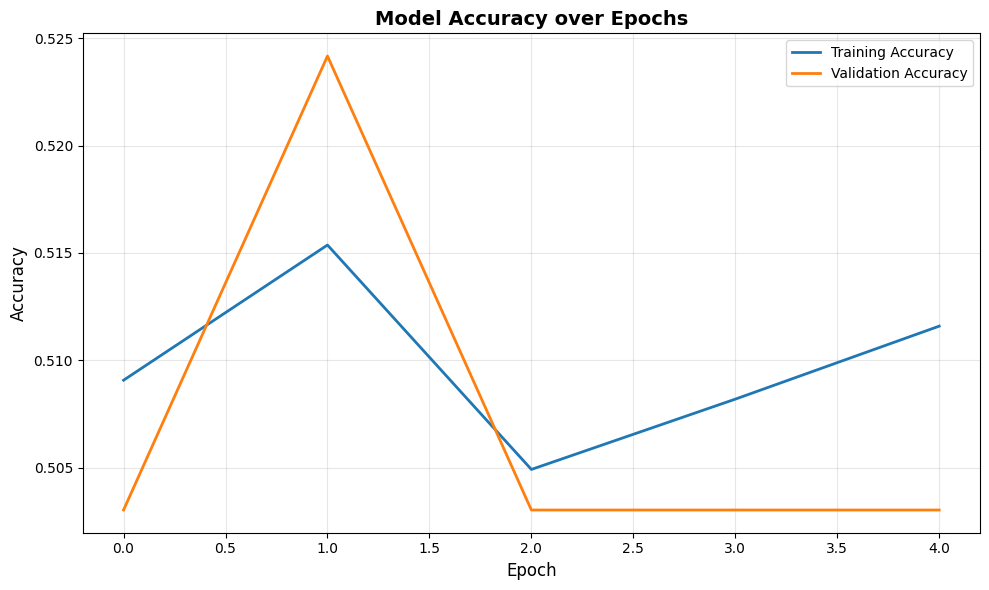

Saved: training_validation_accuracy.png


In [ ]:
# 1. Training vs Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/training_validation_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: training_validation_accuracy.png")

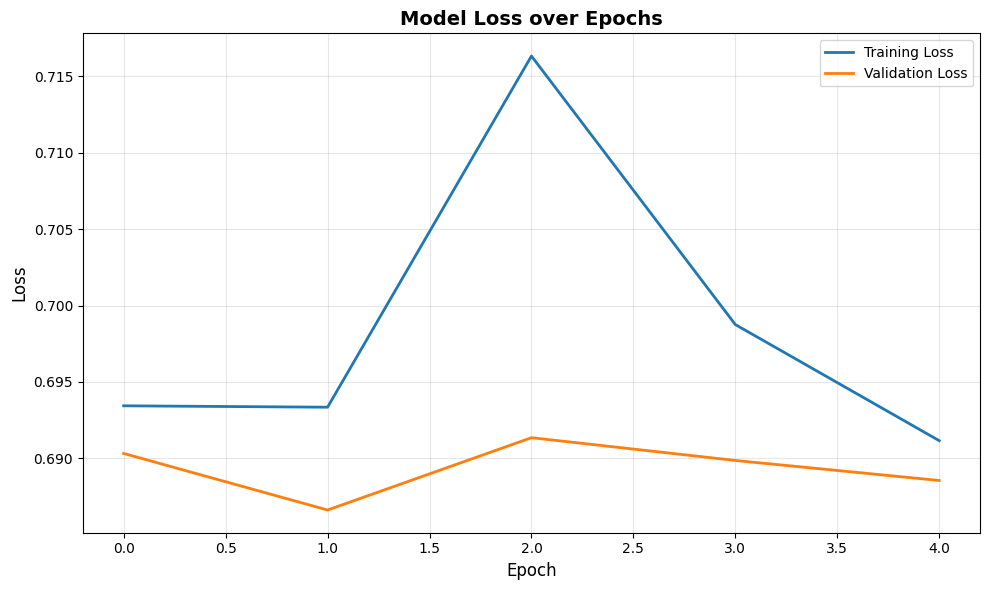

Saved: training_validation_loss.png


In [ ]:
# 2. Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/training_validation_loss.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: training_validation_loss.png")

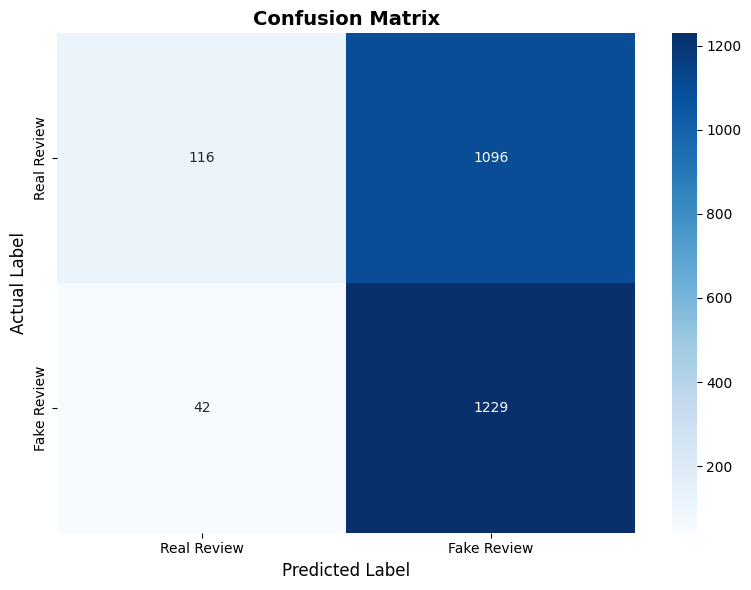

Saved: confusion_matrix.png


In [ ]:
# 3. Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Real Review', 'Fake Review'],
            yticklabels=['Real Review', 'Fake Review'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)
plt.tight_layout()
plt.savefig('visualizations/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: confusion_matrix.png")

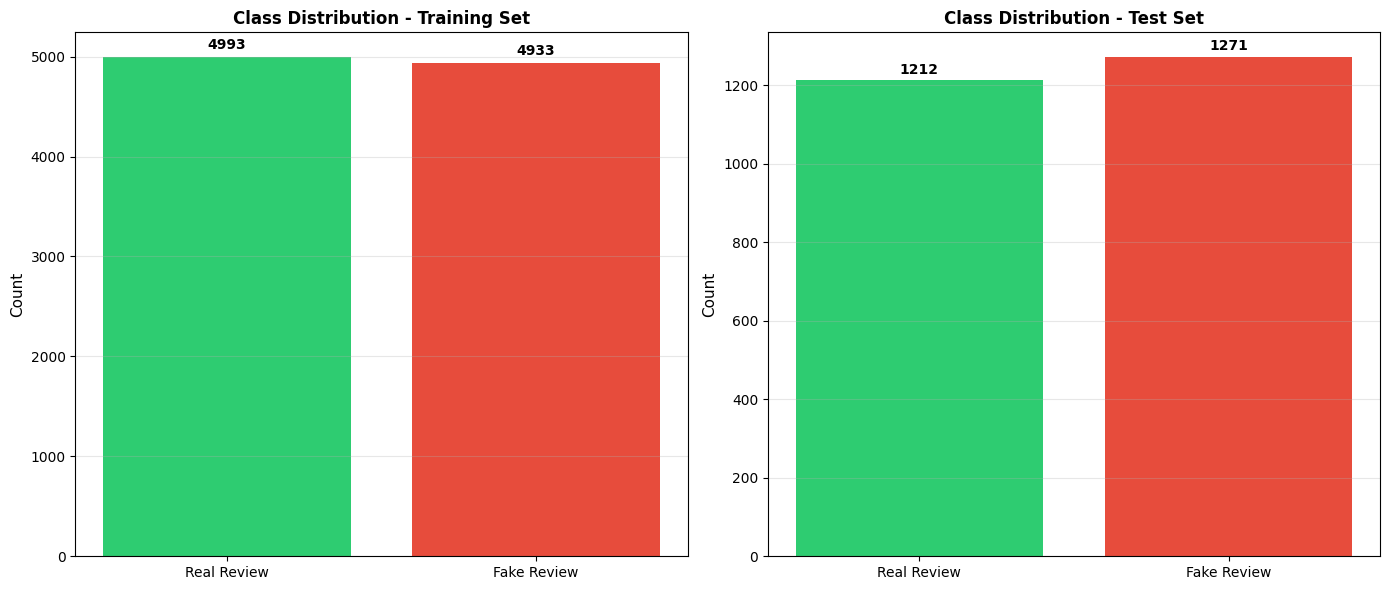

Saved: class_distribution.png


In [ ]:
# 4. Class Distribution in Train and Test Sets
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training set distribution
train_counts = train_df['flagged'].value_counts()
axes[0].bar(['Real Review', 'Fake Review'],
            [train_counts[0], train_counts[1]],
            color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Class Distribution - Training Set', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate([train_counts[0], train_counts[1]]):
    axes[0].text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

# Test set distribution
test_counts = test_df['flagged'].value_counts()
axes[1].bar(['Real Review', 'Fake Review'],
            [test_counts[0], test_counts[1]],
            color=['#2ecc71', '#e74c3c'])
axes[1].set_title('Class Distribution - Test Set', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate([test_counts[0], test_counts[1]]):
    axes[1].text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: class_distribution.png")

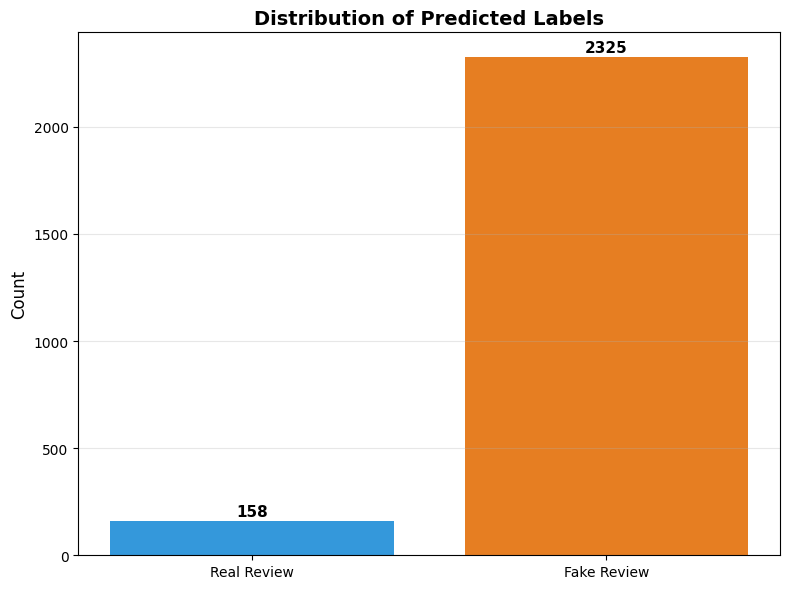

Saved: prediction_distribution.png


In [ ]:
# 5. Prediction Distribution
pred_counts = pd.Series(y_pred).value_counts()
plt.figure(figsize=(8, 6))
plt.bar(['Real Review', 'Fake Review'],
        [pred_counts[0], pred_counts[1]],
        color=['#3498db', '#e67e22'])
plt.title('Distribution of Predicted Labels', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
for i, v in enumerate([pred_counts[0], pred_counts[1]]):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold', fontsize=11)
plt.tight_layout()
plt.savefig('visualizations/prediction_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: prediction_distribution.png")

/tmp/ipython-input-1029818265.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['review_length'] = train_df['cleaned_review'].apply(lambda x: len(x.split()))


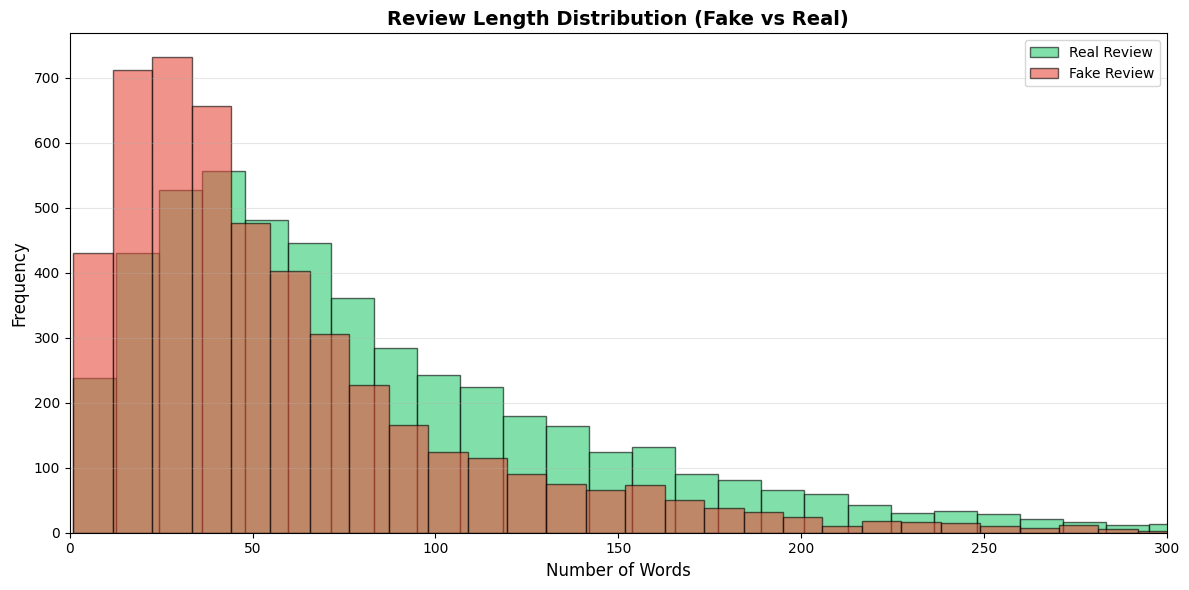

Saved: review_length_distribution.png


In [ ]:
# 6. Review Length Distribution for Fake vs Real Reviews
train_df['review_length'] = train_df['cleaned_review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
plt.hist(train_df[train_df['flagged'] == 0]['review_length'],
         bins=50, alpha=0.6, label='Real Review', color='#2ecc71', edgecolor='black')
plt.hist(train_df[train_df['flagged'] == 1]['review_length'],
         bins=50, alpha=0.6, label='Fake Review', color='#e74c3c', edgecolor='black')
plt.title('Review Length Distribution (Fake vs Real)', fontsize=14, fontweight='bold')
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, axis='y')
plt.xlim(0, 300)
plt.tight_layout()
plt.savefig('visualizations/review_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: review_length_distribution.png")

## 11. Summary Statistics

In [ ]:
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

print("\nDataset Information:")
print(f"  Training samples: {len(train_df)}")
print(f"  Validation samples: {len(X_val)}")
print(f"  Test samples: {len(test_df)}")

print("\nModel Architecture:")
print(f"  Vocabulary size: {vocab_size}")
print(f"  Embedding dimension: {EMBEDDING_DIM}")
print(f"  LSTM units: {LSTM_UNITS}")
print(f"  Dropout rate: {DROPOUT_RATE}")
print(f"  Max sequence length: {MAX_SEQUENCE_LENGTH}")

print("\nTraining Configuration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs trained: {len(history.history['loss'])}")
print(f"  Optimizer: Adam")
print(f"  Loss function: Binary Crossentropy")

print("\nPerformance Metrics:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

print("\nFiles Generated:")
print("  - lstm_fake_review_model.h5")
print("  - predictions.csv")
print("  - visualizations/training_validation_accuracy.png")
print("  - visualizations/training_validation_loss.png")
print("  - visualizations/confusion_matrix.png")
print("  - visualizations/class_distribution.png")
print("  - visualizations/prediction_distribution.png")
print("  - visualizations/review_length_distribution.png")

print("\n" + "="*60)
print("Analysis completed successfully!")
print("="*60)


SUMMARY STATISTICS

Dataset Information:
  Training samples: 9926
  Validation samples: 1986
  Test samples: 2483

Model Architecture:
  Vocabulary size: 10000
  Embedding dimension: 128
  LSTM units: 128
  Dropout rate: 0.5
  Max sequence length: 200

Training Configuration:
  Batch size: 32
  Epochs trained: 5
  Optimizer: Adam
  Loss function: Binary Crossentropy

Performance Metrics:
  Accuracy: 0.5417
  Precision: 0.5286
  Recall: 0.9670
  F1-Score: 0.6835

Files Generated:
  - lstm_fake_review_model.h5
  - predictions.csv
  - visualizations/training_validation_accuracy.png
  - visualizations/training_validation_loss.png
  - visualizations/confusion_matrix.png
  - visualizations/class_distribution.png
  - visualizations/prediction_distribution.png
  - visualizations/review_length_distribution.png

Analysis completed successfully!
